<a href="https://colab.research.google.com/github/Charles8745/gans-in-action/blob/master/gans_in_action_CH8_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import keras

from keras import backend as K
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU, Activation, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, Concatenate, Input, Lambda, Embedding, Multiply
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical


print(f"Pythyon: {sys.version}")
print(f"Keras: {keras.__version__}")

Pythyon: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Keras: 3.8.0


In [ ]:
# Global Parameters
img_rows= 28
img_cols = 28
channel = 1

img_shape = (img_rows, img_cols, channel)

z_dim = 100

num_classes = 10

In [ ]:
# Build CGAN generator
def build_generator(z_dim):
  model = Sequential()

  model.add(Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

  # model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

  # model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

  model.add(Activation('tanh'))

  return model

def build_cgan_generator(z_dim):

  z = Input(shape=(z_dim, ))
  label = Input(shape=(1, ), dtype='int32')

  # 將label轉成長度為z_dim的密集向量，最後輸出為(batch_size, 1 z_dim)
  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

  # 將label embedding展成(batch_size, z_dim)
  label_embedding = Flatten()(label_embedding)

  # noise(z)和label_embedding做Element-wise product
  joined_representation = Multiply()([z, label_embedding])

  # 建立基本生成器
  generator = build_generator(z_dim)

  # 根據合併得標籤生成影像
  conditioned_img = generator(joined_representation)

  return Model([z, label], conditioned_img)

In [ ]:
def build_discriminator(img_shape):

  model = Sequential()

  # Convolutional layer, from 28x28x2 into 14x14x32 tensor
  model.add(
      Conv2D(16,
        kernel_size=4,
        strides=2,
        input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
        padding='same'))

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # # Convolutional layer, from 14x14x64 into 7x7x64 tensor
  model.add(
      Conv2D(32,
        kernel_size=3,
        strides=2,
        input_shape=img_shape,
        padding='same'))

  # # model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  # # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
  # model.add(
  #     Conv2D(128,
  #         kernel_size=3,
  #         strides=2,
  #         input_shape=img_shape,
  #         padding='same'))

  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))

  # Output layer with sigmoid activation
  model.add(Flatten())
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation='sigmoid'))

  return model

def build_cgan_discriminator(img_shape):

  # Input image
  img = Input(shape=img_shape)

  # Label for the input image
  label = Input(shape=(1, ), dtype='int32')

  # Label embedding:
  # ----------------
  # Turns labels into dense vectors of size z_dim
  # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
  label_embedding = Embedding(num_classes,
                  np.prod(img_shape),
                  input_length=1)(label)

  # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
  label_embedding = Flatten()(label_embedding)

  # Reshape label embeddings to have same dimensions as input images
  label_embedding = Reshape(img_shape)(label_embedding)

  # Concatenate images with their label embeddings
  concatenated = Concatenate(axis=-1)([img, label_embedding])

  discriminator = build_discriminator(img_shape)

  # Classify the image-label pair
  classification = discriminator(concatenated)

  return Model([img, label], classification)

In [ ]:
def build_cgan(generator, discriminator):

  # Random noise vector z
  z = Input(shape=(z_dim, ))

  # Image label
  label = Input(shape=(1, ))

  # Generated image for that label
  img = generator([z, label])

  classification = discriminator([img, label])

  # Combined Generator -> Discriminator model
  # G([z, lablel]) = x*
  # D(x*) = classification
  model = Model([z, label], classification)

  return model

In [ ]:
# Build and compile the Discriminator
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
# discriminator.trainable = False

# Build and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

  # Load the MNIST dataset
  (X_train, y_train), (_, _) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------
    discriminator.trainable = True

    # Get a random batch of real images and their labels
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels], verbose=0)

    # Train the Discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train the Generator
    # ---------------------
    discriminator.trainable = False

    # Generate a batch of noise vectors
    z = np.random.normal(0, 1, (batch_size, z_dim))

    # Get a batch of random labels
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

    # Train the Generator
    g_loss = cgan.train_on_batch([z, labels], real)

    if (iteration + 1) % sample_interval == 0:

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
            (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # Output sample of generated images
      sample_images()

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Get image labels 0-9
  labels = np.arange(0, 10).reshape(-1, 1)

  # Generate images from random noise
  gen_imgs = generator.predict([z, labels], verbose=0)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
                image_grid_columns,
                figsize=(10, 4),
                sharey=True,
                sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
      for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels[cnt])
        cnt += 1

500 [D loss: 0.006178, acc.: 99.70%] [G loss: 0.148545]


/tmp/ipython-input-15-3244304507.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i, j].set_title("Digit: %d" % labels[cnt])


1000 [D loss: 0.003089, acc.: 99.85%] [G loss: 0.074273]
1500 [D loss: 0.002059, acc.: 99.90%] [G loss: 0.049515]
2000 [D loss: 0.001544, acc.: 99.92%] [G loss: 0.037136]
2500 [D loss: 0.001235, acc.: 99.94%] [G loss: 0.029709]
3000 [D loss: 0.001029, acc.: 99.95%] [G loss: 0.024758]
3500 [D loss: 0.000882, acc.: 99.96%] [G loss: 0.021221]
4000 [D loss: 0.000772, acc.: 99.96%] [G loss: 0.018568]
4500 [D loss: 0.000686, acc.: 99.97%] [G loss: 0.016505]
5000 [D loss: 0.000618, acc.: 99.97%] [G loss: 0.014855]
5500 [D loss: 0.000561, acc.: 99.97%] [G loss: 0.013504]
6000 [D loss: 0.000515, acc.: 99.97%] [G loss: 0.012379]
6500 [D loss: 0.000475, acc.: 99.98%] [G loss: 0.011427]
7000 [D loss: 0.000441, acc.: 99.98%] [G loss: 0.010610]
7500 [D loss: 0.000412, acc.: 99.98%] [G loss: 0.009903]
8000 [D loss: 0.000386, acc.: 99.98%] [G loss: 0.009284]
8500 [D loss: 0.000363, acc.: 99.98%] [G loss: 0.008738]
9000 [D loss: 0.000343, acc.: 99.98%] [G loss: 0.008253]
9500 [D loss: 0.000325, acc.: 9

/tmp/ipython-input-15-3244304507.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(image_grid_rows,


11000 [D loss: 0.000281, acc.: 99.99%] [G loss: 0.006752]
11500 [D loss: 0.000269, acc.: 99.99%] [G loss: 0.006458]
12000 [D loss: 0.000257, acc.: 99.99%] [G loss: 0.006189]


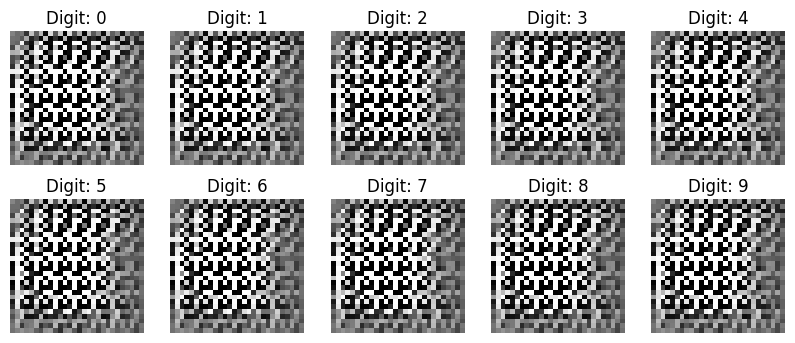

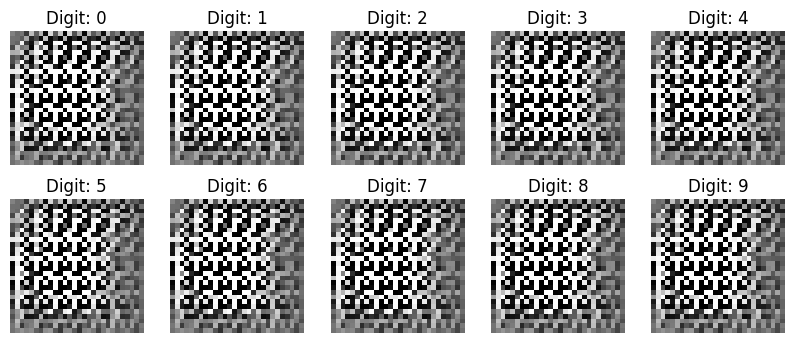

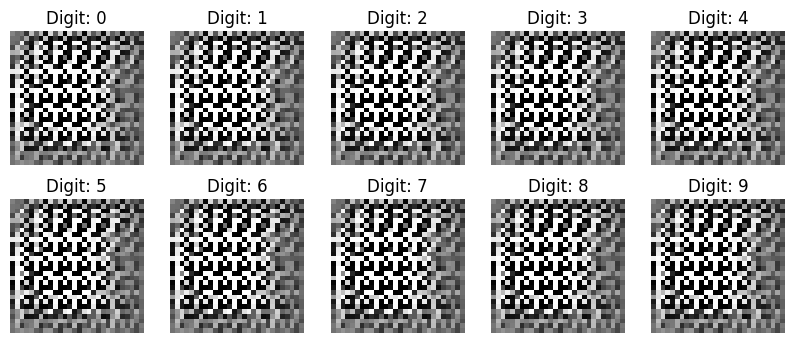

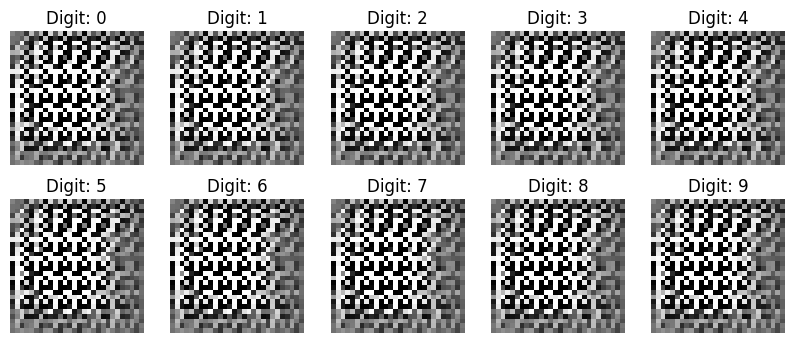

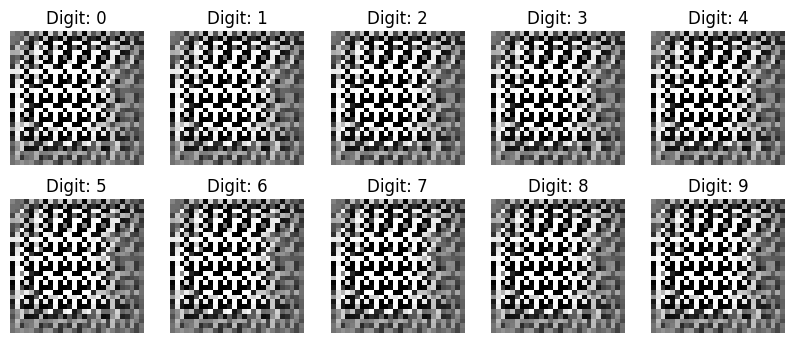

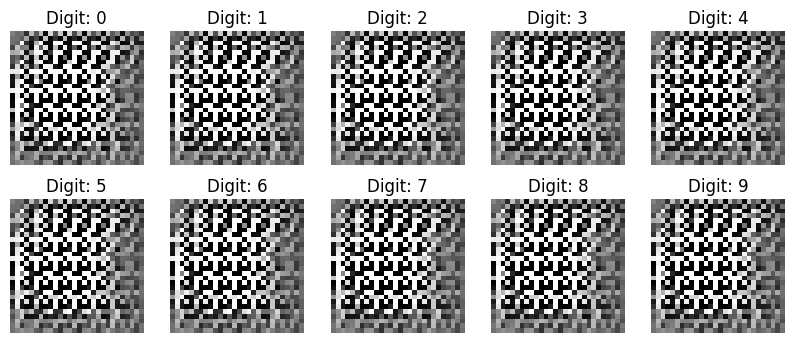

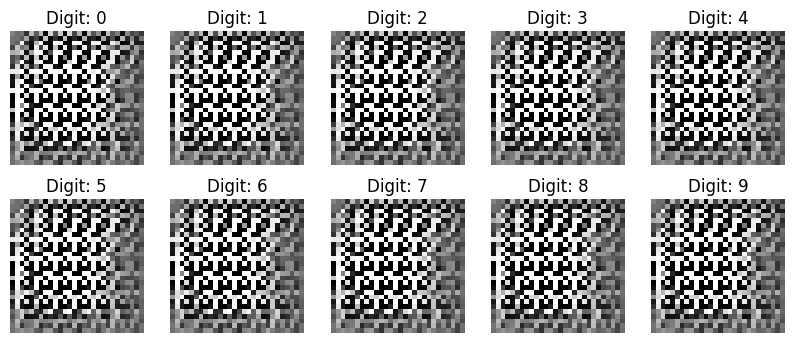

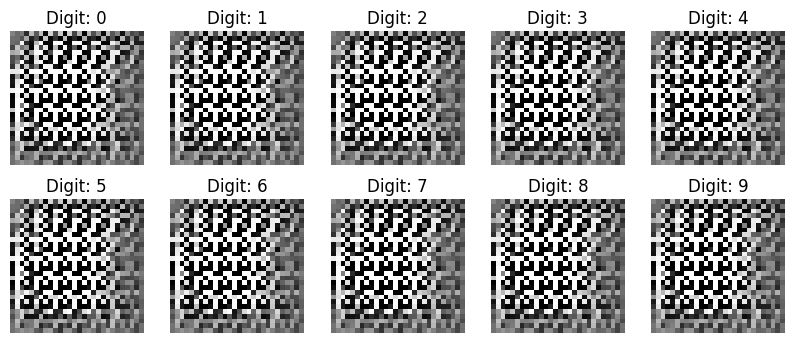

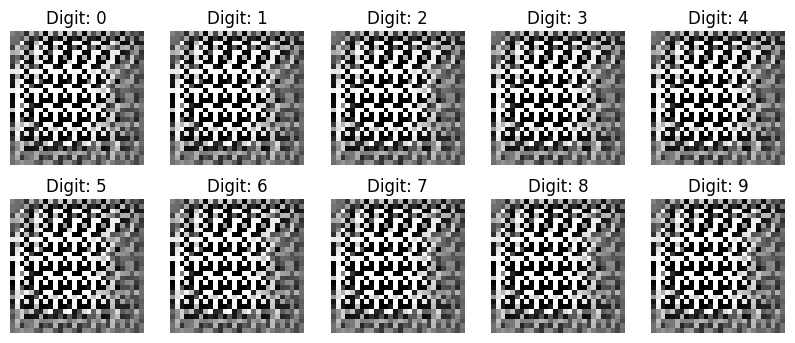

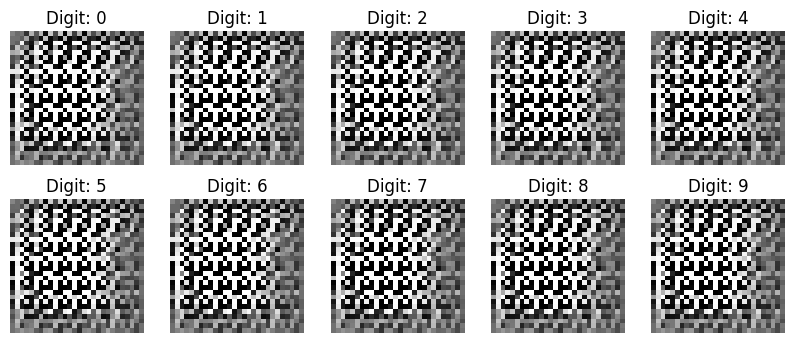

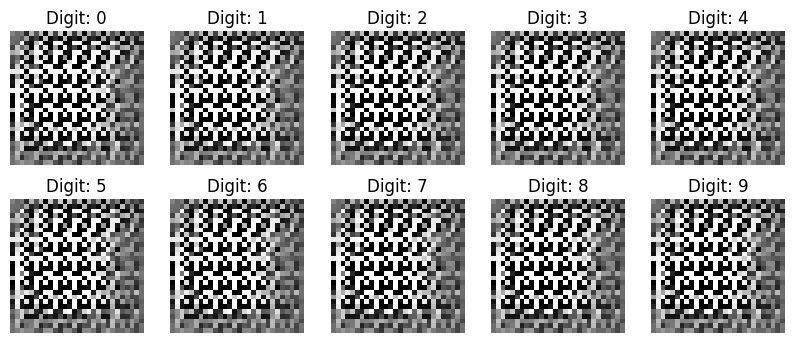

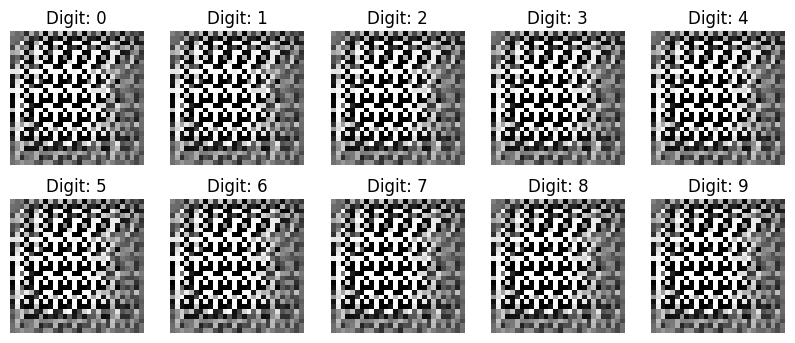

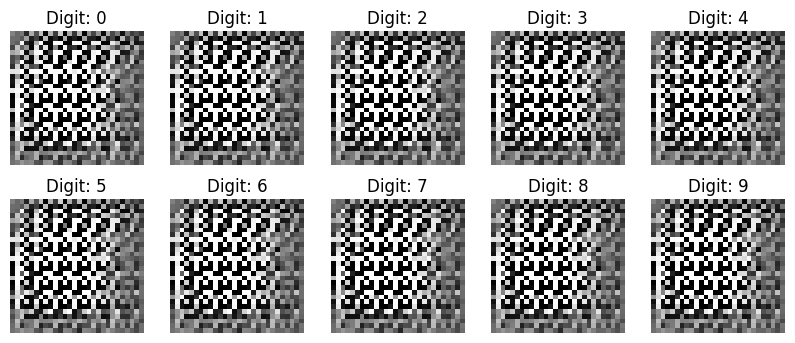

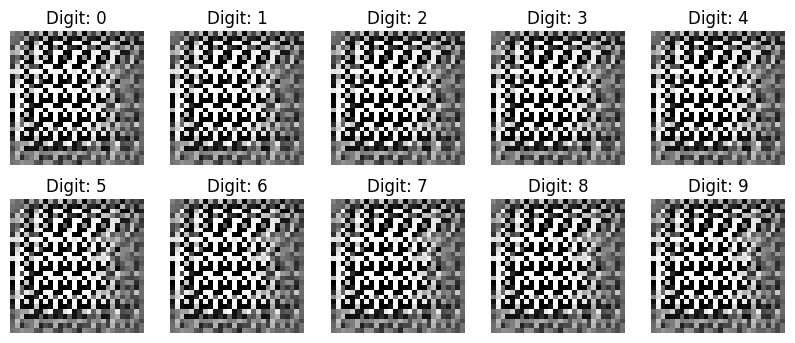

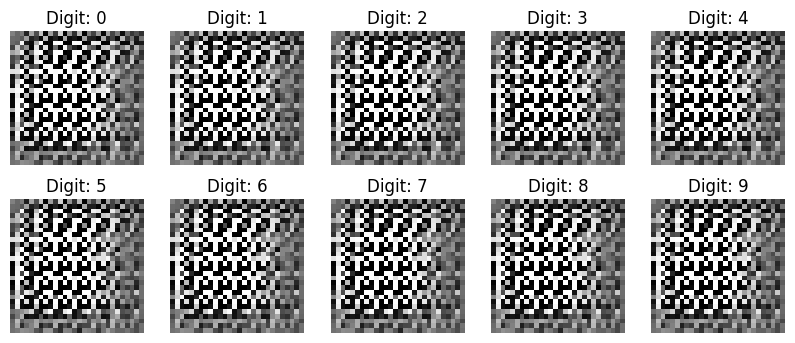

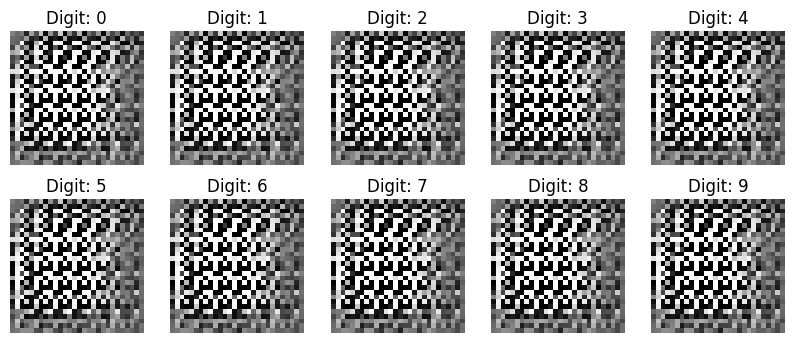

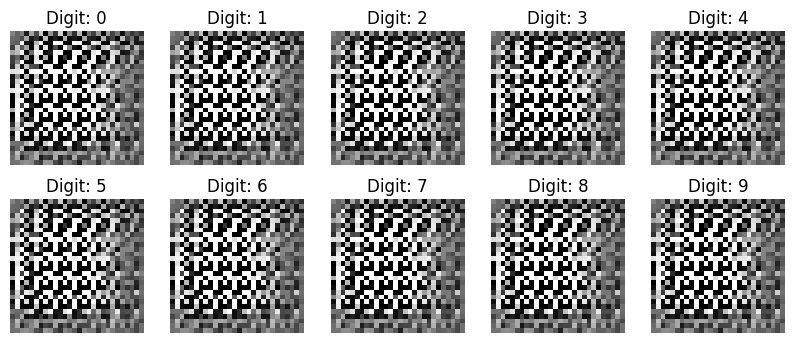

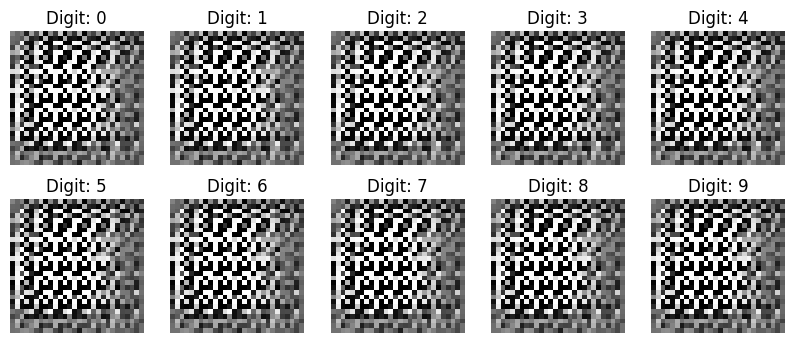

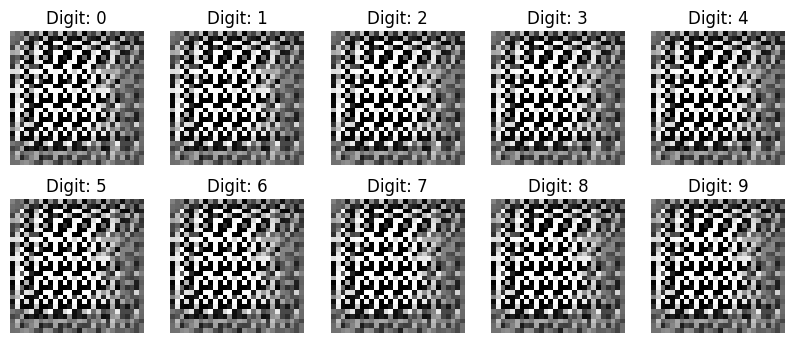

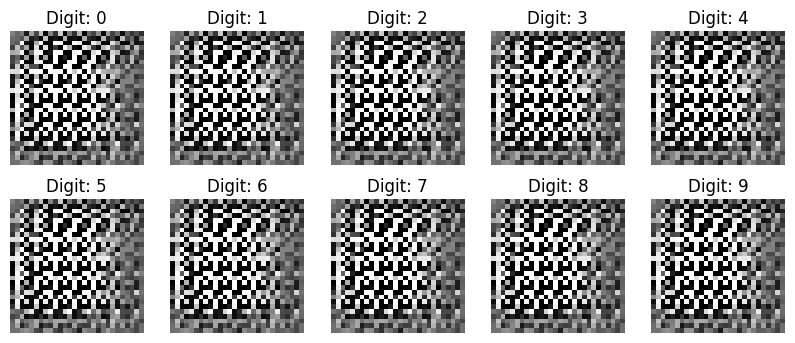

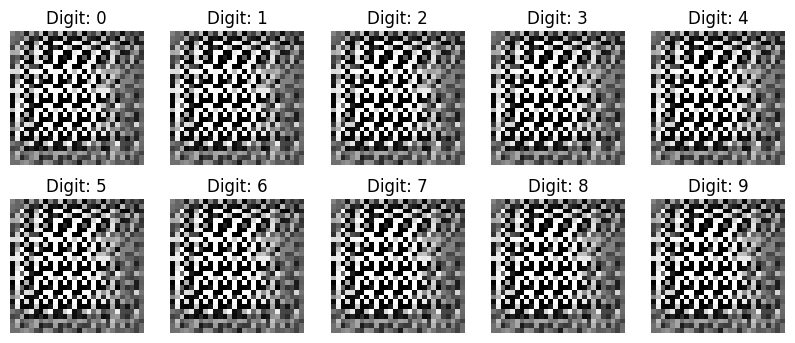

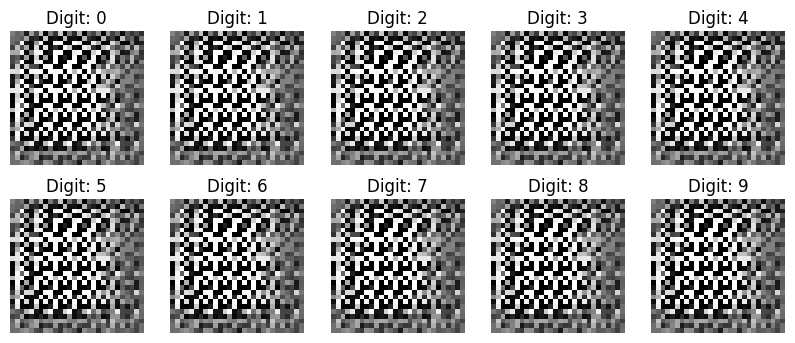

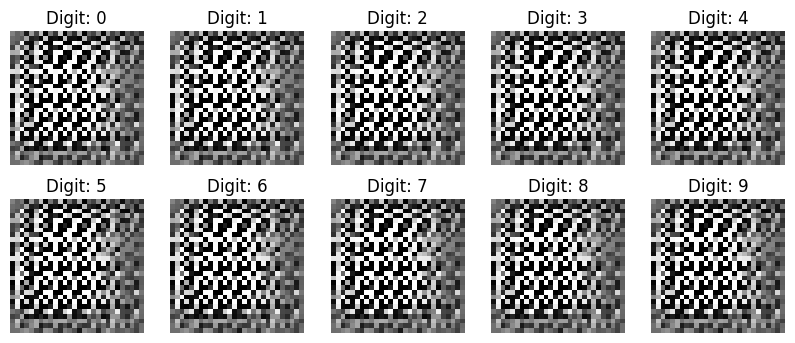

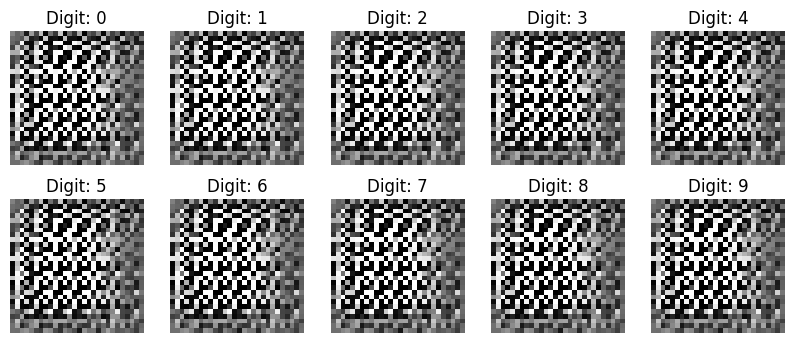

In [ ]:
# Set hyperparameters
iterations = 12000
batch_size = 32
sample_interval = 500

# Train the CGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step


/tmp/ipython-input-10-2592619231.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW


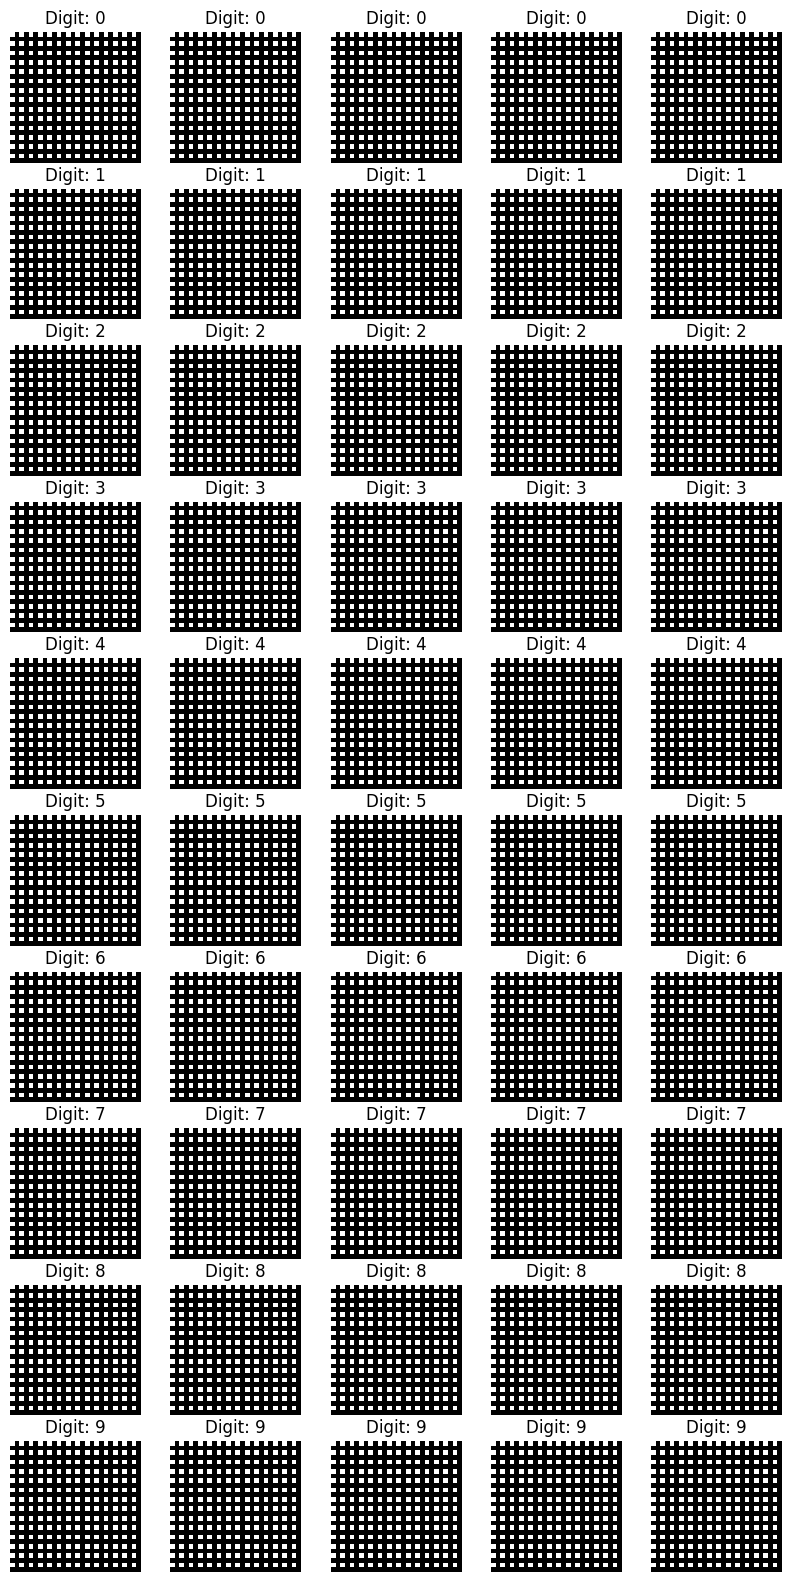

In [ ]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
  for j in range(image_grid_columns):
    # Output a grid of images
    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
    axs[i, j].axis('off')
    axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
    cnt += 1